# Gaining Data Insight from 2014 Reddit Comments

#### Section 1: Social Analytics

##### **Question 1:** What were the top 50 most popular subreddits in terms of the number of active users?

In [2]:
from google.cloud import bigquery

In [5]:
# Function to request data from BigQuery
def query_stackoverflow():
    client = bigquery.Client()
    query_job = client.query(f"SELECT subreddit, user_count FROM (SELECT subreddit, COUNT(DISTINCT(author)) as user_count FROM `coursework-reddit-368616.reddit_2014.2014` GROUP BY subreddit) ORDER BY user_count DESC LIMIT 50"
    )

    results = query_job.result() 

    for row in results:
        print("{} : {} users".format(row.subreddit, row.user_count))


if __name__ == "__main__":
    query_stackoverflow()

AskReddit : 1942569 users
funny : 1128979 users
pics : 1016309 users
AdviceAnimals : 725298 users
videos : 694278 users
IAmA : 682596 users
todayilearned : 628701 users
WTF : 600692 users
gaming : 557986 users
worldnews : 454644 users
aww : 441006 users
gifs : 430455 users
movies : 409360 users
leagueoflegends : 367874 users
Music : 367405 users
news : 365402 users
explainlikeimfive : 318640 users
technology : 280991 users
mildlyinteresting : 274873 users
Showerthoughts : 226466 users
trees : 223698 users
books : 185341 users
tifu : 182660 users
science : 172440 users
pcmasterrace : 165176 users
politics : 162613 users
Fitness : 157684 users
atheism : 147571 users
cringepics : 146927 users
LifeProTips : 145961 users
friendsafari : 143416 users
television : 139235 users
gonewild : 138982 users
nfl : 131266 users
soccer : 127589 users
DotA2 : 126041 users
TwoXChromosomes : 125460 users
sex : 125382 users
buildapc : 124353 users
Games : 123026 users
food : 121121 users
millionairemakers :

The popularity of each subreddit was measured in terms of number of users posting comments as it reflects the level of engagement with each topic. The subreddits with the highest number of active users are listed above, with the top 3 being r/AskReddit, r/funny, and r/pics.

In [6]:
import pandas as pd

# Loading data into dataframe
client = bigquery.Client()
query = f"SELECT subreddit, user_count FROM (SELECT subreddit, COUNT(DISTINCT(author)) as user_count FROM `coursework-reddit-368616.reddit_2014.2014` GROUP BY subreddit) ORDER BY user_count DESC"
df = client.query(query).to_dataframe()

df.head()

,subreddit,user_count
0,AskReddit,1942569
1,funny,1128979
2,pics,1016309
3,AdviceAnimals,725298
4,videos,694278


##### **Question 2:** Plot PDF of number of users for all subreddits

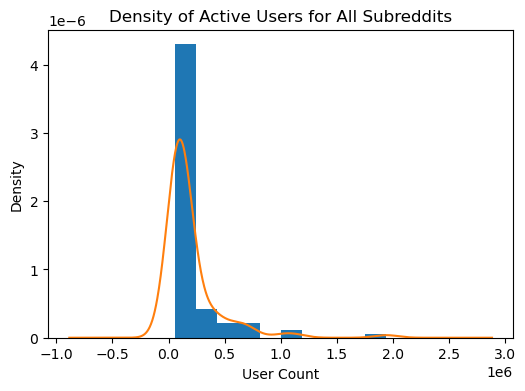

In [8]:
import seaborn as sb
import matplotlib.pyplot as plt

# Plotting density of user count for all subreddits

fig, ax = plt.subplots(figsize = (6,4))

df['user_count'][:100].plot(kind = "hist", density = True)
df['user_count'][:100].plot(kind = "kde")

ax.set_xlabel("User Count")
ax.set_title("Density of Active Users for All Subreddits")
plt.show()

We can infer from the distribution's peak density that the most likely number of active users for each subreddit is around 150,000 - 200,000.

#### **Question 3:** Proportion of active users 

In [9]:
# Shifting columns down and computing proportion
df['prev_count'] = df['user_count'].shift(1)
df['Proportion'] = df['prev_count']/df['user_count']
df['Proportion'] = df['Proportion'].map('1: {:,.2f}'.format)
df.head(15)

,subreddit,user_count,prev_count,Proportion
0,AskReddit,1942569,NaN,1: nan
1,funny,1128979,1942569.0,1: 1.72
2,pics,1016309,1128979.0,1: 1.11
3,AdviceAnimals,725298,1016309.0,1: 1.40
4,videos,694278,725298.0,1: 1.04
5,IAmA,682596,694278.0,1: 1.02
6,todayilearned,628701,682596.0,1: 1.09
7,WTF,600692,628701.0,1: 1.05
8,gaming,557986,600692.0,1: 1.08
9,worldnews,454644,557986.0,1: 1.23


The proportion column reflects the ratio of active users in i (relatively higher ranked subreddit) to 1 active user in i+1 ranked subreddit.   
Taking a look at the top 2 subreddits, r/AskReddit and r/funny, we observe that r/AskReddit has 1.72x more active users than r/funny. This is almost double the number of users.  
However, the proportions are closer to 1 as we move down the ranks (i), confirming that the number of active users in each subreddit does not decrease dramatically as you move down the ranks, but is rather a gentle slope down. 

#### Section 2: Behavioural Analytics

##### **Question 1:** How many comments does each of these subreddits receive in a given hour of the day

In [32]:
client = bigquery.Client()
query = f"SELECT subreddit, body, created_utc FROM `coursework-reddit-368616.reddit_2014.2014` WHERE subreddit in ('funny','houston', 'gaming', 'askscience', 'unitedkingdom')"
df2 = client.query(query).to_dataframe()

In [33]:
import pandas as pd

# Converting created_utc to timestamp
df2['created_utc'].apply(pd.Timestamp.fromtimestamp)
df2['timestamp'] = df2['created_utc'].apply(pd.Timestamp.fromtimestamp)

In [38]:
# Grouping comments by subreddit
grouped2 = df2.groupby([df2.timestamp.dt.hour, 'subreddit']).body.count()
grouped2 = pd.DataFrame(data=grouped2)

display(grouped2)

The table above shows the number of comments posted on each subreddit at every hour of the day.

##### **Question 2 - 3:** Plot and analyse the curves

*Note: My kernel kept disconnecting every time I tried to request a query containing the AskReddit subreddit data, so for this section I used the second-most active subreddit - r/funny.*

Text(0.5, 1.0, 'Number of Comments Posted on Subreddits Per Hour')

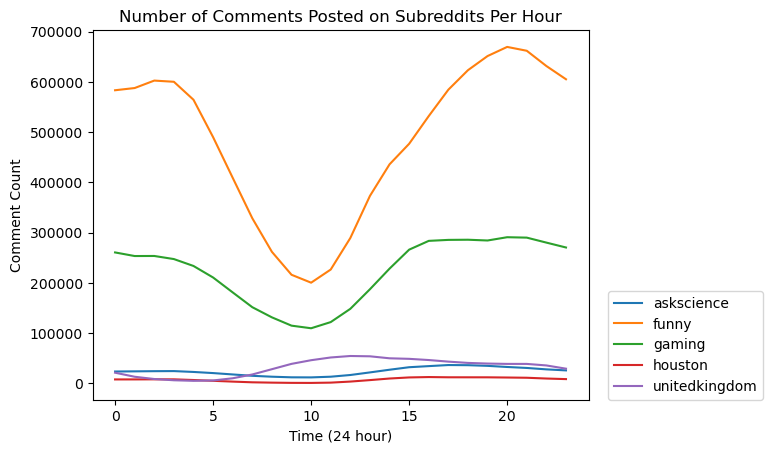

In [14]:
import seaborn as sb
import matplotlib.pyplot as plt

# Plotting the curves
sb.lineplot(data=grouped2, x='timestamp', y='body', hue='subreddit')
plt.xlabel('Time (24 hour)')
plt.ylabel('Comment Count')
plt.legend(loc=(1.04, 0))
plt.title('Number of Comments Posted on Subreddits Per Hour')

The plot shows the number of comments posted on each subreddit at every hour of the day.
r/funny is significantly more active relative to the other subreddits, peaking at around 20:00 UTC with approximately 700,000 comments. 
The activity of all subreddits appears to drop around the same time of day (between 8:00 - 12:00 UTC), except for the r/unitedkingdom, which peaks around 12:00 UTC. 
The activity curve of the r/funny and r/gaming in comparison to r/unitedkingdom could possibly indicate a difference in timezones of the users in the subreddits. 
However, other factors might impact the activity. For example, we could assume that it is not a difference in timezone and that both users were on UTC, a possible factor for r/gaming being less active around noon is because people are unlikely to be gaming during work and school hours. 

Text(0.5, 1.0, 'Number of Comments Posted on Subreddits Per Hour')

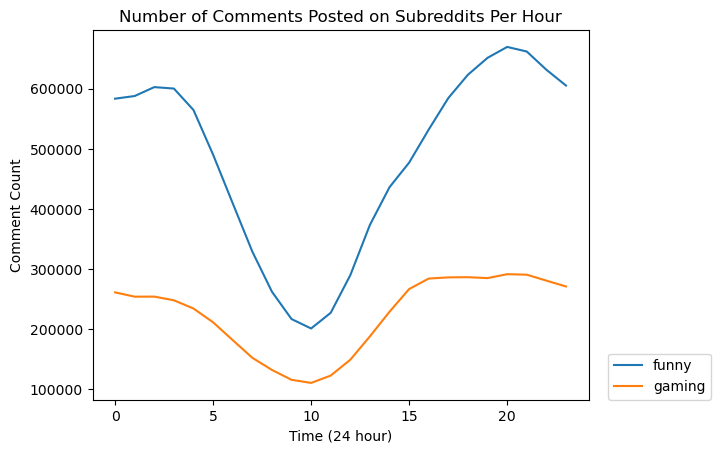

In [15]:
temp = grouped2.query('subreddit == "funny" | subreddit == "gaming"')
sb.lineplot(data=temp, x='timestamp', y='body', hue='subreddit')
plt.xlabel('Time (24 hour)')
plt.ylabel('Comment Count')
plt.legend(loc=(1.04, 0))
plt.title('Number of Comments Posted on Subreddits Per Hour')

Taking a closer look at the curves of r/gaming and r/funny, we observe that they have very similar activity throughout hours of the day. This could indicate that similar types of people are active on both subreddits, or that the activity of one offsets another. We observe that the activity in r/funny drops right after the comment count for r/gaming begins to decrease (approx. 3:00 UTC). 

Text(0.5, 1.0, 'Number of Comments Posted on Subreddits Per Hour')

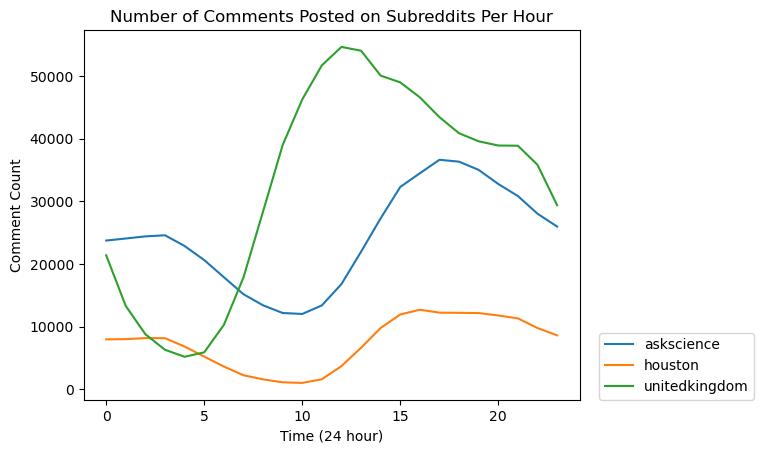

In [16]:
temp = grouped2.query('subreddit == "houston" | subreddit == "unitedkingdom" | subreddit == "askscience"')
sb.lineplot(data=temp, x='timestamp', y='body', hue='subreddit')
plt.xlabel('Time (24 hour)')
plt.ylabel('Comment Count')
plt.legend(loc=(1.04, 0))
plt.title('Number of Comments Posted on Subreddits Per Hour')

The plot above is a closer look at the activity of r/unitedkingdom, r/houston, and r/askscience throughout every hour of the day. We observe that the activity of r/houston plunges between 7:00 - 11:00 UTC, while the activity of r/unitedkingdom increases around time, and peaks at around 12:00 UTC. 
7:00 - 11:000 UTC is 1:00 - 5:00 CST (Houston timezone), so we can conclude that the reason the activity of r/houston plunges around the time r/unitedkingdom is active is because the users are in different timezones. 
Another thing to observe is the shape the r/houston and r/askscience curves, which is almost identical. This may suggest that the users commenting on r/askscience might be in the same timezone as those in r/houston. 

#### Section 3: Language Analytics

*Note: My kernel kept disconnecting when I would try to pass large query containing all 5 subreddits - I only managed to make it work for r/houston and r/unitedkingdom. I completed the language analytics section based on the results I got for those 2 subreddits.*

In [3]:
client = bigquery.Client()
query1 = f"SELECT subreddit, body FROM `coursework-reddit-368616.reddit_2014.2014` WHERE subreddit in ('houston') and body NOT IN ('[deleted]')"
houston_df = client.query(query1).to_dataframe()
query2 = f"SELECT subreddit, body FROM `coursework-reddit-368616.reddit_2014.2014` WHERE subreddit in ('unitedkingdom') and body NOT IN ('[deleted]')"
uk_df = client.query(query2).to_dataframe()

In [4]:
houston_df['body'] = houston_df['body'].astype(str).str.lower()
uk_df['body'] = uk_df['body'].astype(str).str.lower()

In [5]:
# Installing NLTK for text analysis
!pip install nltk

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.10.31-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (757 kB)


In [6]:
import nltk
from nltk.tokenize import RegexpTokenizer

In [7]:
regexp = RegexpTokenizer('\w+')

houston_df['text_token']=houston_df['body'].apply(regexp.tokenize)
uk_df['text_token']=uk_df['body'].apply(regexp.tokenize)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words("english")
my_stopwords = ['like', 'http', 'would']
stopwords.extend(my_stopwords)

In [10]:
houston_df['text_token'] = houston_df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
uk_df['text_token'] = uk_df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])

In [11]:
houston_df['text_string'] = houston_df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
uk_df['text_string'] = uk_df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [12]:
all_words_1 = ' '.join([word for word in houston_df['text_string']])
all_words_2 = ' '.join([word for word in uk_df['text_string']])

In [13]:
import nltk
nltk.download('punkt')
tokenized_words_1 = nltk.tokenize.word_tokenize(all_words_1)
tokenized_words_2 = nltk.tokenize.word_tokenize(all_words_2)

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
from nltk.probability import FreqDist

fdist_1 = FreqDist(tokenized_words_1)
fdist_2 = FreqDist(tokenized_words_2)

In [15]:
houston_df['text_string_fdist'] = houston_df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist_1[item] >= 1 ]))
uk_df['text_string_fdist'] = uk_df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist_2[item] >= 1 ]))

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

houston_df['text_string_lem'] = houston_df['text_string_fdist'].apply(wordnet_lem.lemmatize)
uk_df['text_string_lem'] = uk_df['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [18]:
houston_df['is_equal']= (houston_df['text_string_fdist']==houston_df['text_string_lem'])
uk_df['is_equal']= (uk_df['text_string_fdist']==uk_df['text_string_lem'])

In [19]:
all_words_lem_1 = ' '.join([word for word in houston_df['text_string_lem']])
all_words_lem_2 = ' '.join([word for word in uk_df['text_string_lem']])

##### Question 1: Top 10 frequent words

In [21]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words_1 = nltk.word_tokenize(all_words_lem_1)
fd_1 = FreqDist(words_1)
fd_1.most_common(10)

[('houston', 19528),
 ('get', 18712),
 ('people', 17333),
 ('one', 16532),
 ('com', 15181),
 ('good', 12916),
 ('know', 11063),
 ('time', 10772),
 ('think', 10753),
 ('www', 10512)]

In [22]:
words_2 = nltk.word_tokenize(all_words_lem_2)
fd_2 = FreqDist(words_2)
fd_2.most_common(10)

[('people', 165022),
 ('think', 86476),
 ('one', 84516),
 ('get', 84362),
 ('even', 53507),
 ('really', 52979),
 ('much', 52079),
 ('time', 51329),
 ('know', 50017),
 ('well', 47629)]

In [25]:
import pandas as pd
houston_top_10 = fd_1.most_common(10)
houston_fdist = pd.Series(dict(houston_top_10))

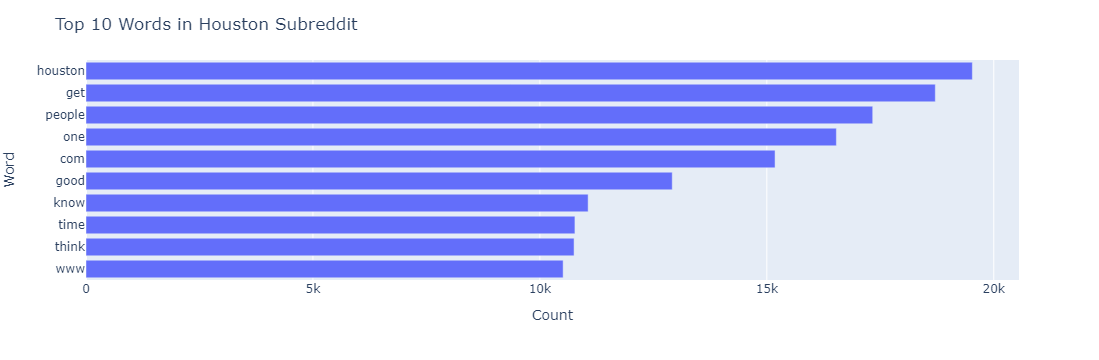

In [27]:
import plotly.express as px

fig = px.bar(y=houston_fdist.index, x=houston_fdist.values)
fig.update_layout(title="Top 10 Words in Houston Subreddit", xaxis_title="Count", yaxis_title="Word", barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

Two of the most common words used are "com" and "www" which could indicate that people post many links to websites on r/houston. 

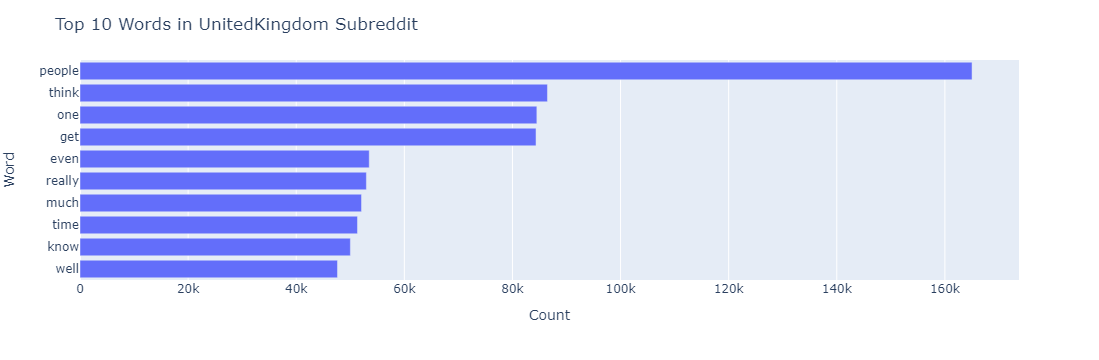

In [29]:
uk_top_10 = fd_2.most_common(10)
uk_fdist = pd.Series(dict(uk_top_10))

fig = px.bar(y=uk_fdist.index, x=uk_fdist.values)
fig.update_layout(title="Top 10 Words in UnitedKingdom Subreddit", xaxis_title="Count", yaxis_title="Word", barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

The top 10 most used words in r/houston and r/unitedkingdom are extremely similar, with both containing: 'one', 'people', 'get', 'think', 'time'. 
Two words that are interesting to compare are 'well' in r/unitedkingdom and 'good' in r/houston' because they are different but also almost the same. The words 'well' and 'good' are synonyms but the use of 'well' is generally more common in the United Kingdom. 

Text(0.5, 1.0, 'Frequency of Word Ordered By Rank (r/Houston)')

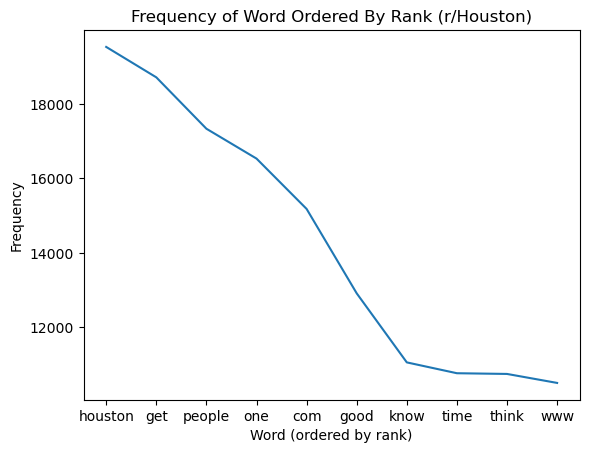

In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(houston_fdist)
plt.xlabel('Word (ordered by rank)')
plt.ylabel('Frequency')
plt.title('Frequency of Word Ordered By Rank (r/Houston)')

Text(0.5, 1.0, 'Frequency of Word Ordered By Rank (r/unitedkingdom)')

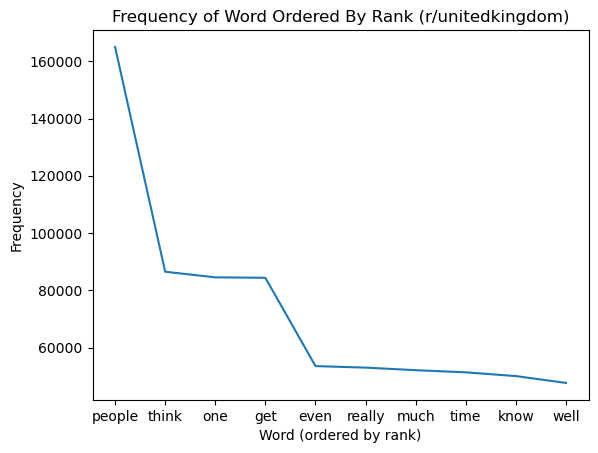

In [31]:
plt.plot(uk_fdist)
plt.xlabel('Word (ordered by rank)')
plt.ylabel('Frequency')
plt.title('Frequency of Word Ordered By Rank (r/unitedkingdom)')

Zipf’s Law is a distribution stating that for some data sets, such as a linguistic corpus, the rank and frequency have an inverse relationship. This means that as the frequency of an item increases, it’s rank value will decrease (1 is top rank, so decrease in value here means higher rank). 
The plot of word frequency in both r/houston and r/unitedkingdom subreddits confirm Zipf’s Law. The order of the words on the x-axis represents their rank, and we observe that as x (rank) increases, y (frequency) promptly decreases. 